In [ ]:
import pandas as pd
import numpy as np

# Cargar datos y convertir a numéricos
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

# Eliminar columnas no numéricas y convertir
X_train = train_df.drop(columns=["paciente_id", "target"]).apply(pd.to_numeric, errors="coerce").dropna()
y_train = train_df.loc[X_train.index, "target"].values.reshape(-1, 1)
X_test = test_df.drop(columns=["paciente_id"]).apply(pd.to_numeric, errors="coerce").dropna()

# Normalizar
X_train_normalized = normalize(X_train.values.astype(np.float64))
X_test_normalized = normalize(X_test.values.astype(np.float64))

# Añadir bias
X_train_final = np.hstack([np.ones((X_train_normalized.shape[0], 1)), X_train_normalized])
X_test_final = np.hstack([np.ones((X_test_normalized.shape[0], 1)), X_test_normalized])

In [ ]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def train_logistic_regression(X, y, lr=0.01, epochs=1000):
    m, n = X.shape
    theta = np.zeros((n, 1))
    bias = 0
    loss_history = []

    for epoch in range(epochs):
        z = np.dot(X, theta) + bias
        y_hat = sigmoid(z)

        loss = compute_loss(y, y_hat)
        loss_history.append(loss)

        dz = y_hat - y
        dw = np.dot(X.T, dz) / m
        db = np.sum(dz) / m

        theta -= lr * dw
        bias -= lr * db

    return theta, bias, loss_history


In [ ]:
def predict(X, theta, bias, threshold=0.5):
    probs = sigmoid(np.dot(X, theta) + bias)
    return (probs >= threshold).astype(int)

def compute_f1_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    if tp + fp == 0 or tp + fn == 0:
        return 0.0  # evitar división por cero

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        return 0.0

    return 2 * (precision * recall) / (precision + recall)

def normalize(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    # Evitar división por cero
    norms[norms == 0] = 1
    return X / norms



In [ ]:
import pandas as pd
import numpy as np

# Cargar tu dataframe (asegúrate de que esté en tu entorno)
train_df = pd.read_csv("train_df.csv")  # Reemplaza con la ruta a tu archivo CSV
df = train_df.copy()
df = df.drop(columns=["paciente_id"])         # 1. Eliminar ID
df["genero"] = df["genero"].map({"M": 1, "F": 0})  # 2. Codificar genero

X = df.drop(columns=["target"])
y = df["target"].values.reshape(-1, 1)

# 3. Estandarizar variables numéricas (menos 'genero')
numeric_cols = X.columns.tolist()
numeric_cols.remove("genero")

means = X[numeric_cols].mean()
stds = X[numeric_cols].std()
X[numeric_cols] = (X[numeric_cols] - means) / stds

X_final = X.values  # X_final vuelve a existir


In [ ]:
def train_val_split(X, y, val_ratio=0.2, seed=42):
    np.random.seed(seed)
    m = X.shape[0]
    indices = np.random.permutation(m)
    val_size = int(m * val_ratio)
    
    val_idx = indices[:val_size]
    train_idx = indices[val_size:]
    
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    
    return X_train, y_train, X_val, y_val


In [ ]:
X_train, y_train, X_val, y_val = train_val_split(X_final, y)
theta, bias, losses = train_logistic_regression(X_train, y_train, lr=0.1, epochs=1000)
y_val_pred = predict(X_val, theta, bias)
f1_val = compute_f1_score(y_val.ravel(), y_val_pred.ravel())

print("F1-Score en Validación:", f1_val)


In [ ]:
learning_rates = [0.01, 0.05, 0.1, 0.2]
epoch_list = [500, 1000, 2000]

best_f1 = 0
best_params = (None, None)

print("Probando combinaciones...\n")

for lr in learning_rates:
    for epochs in epoch_list:
        theta, bias, _ = train_logistic_regression(X_train, y_train, lr=lr, epochs=epochs)
        y_val_pred = predict(X_val, theta, bias)
        f1 = compute_f1_score(y_val.ravel(), y_val_pred.ravel())
        
        print(f"lr = {lr}, epochs = {epochs} => F1-score: {f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_params = (lr, epochs)

print("\n✅ Mejor combinación:")
print(f"Learning Rate: {best_params[0]}")
print(f"Epochs: {best_params[1]}")
print(f"F1-Score: {best_f1:.4f}")


In [ ]:
theta_final, bias_final, _ = train_logistic_regression(X_final, y, lr=0.01, epochs=500)

test_df = pd.read_csv(r"C:\Users\dfqo2\Desktop\ALC\Kaggle\Proyecto2\test_df.csv")
test_df = test_df.drop(columns=["paciente_id"])  # Eliminar ID
test_df["genero"] = test_df["genero"].map({"M": 1, "F": 0})  # Codificar genero



In [ ]:
# Excluir columnas no numéricas o irrelevantes
train_columns = [col for col in train_df.columns if col not in ['paciente_id', 'target']]

# Dejar solo esas columnas en el test
X_test = test_df[train_columns].apply(pd.to_numeric, errors="coerce")

# Rellenar valores faltantes
X_test = X_test.fillna(X_test.mean())

# Normalizar
X_test_normalized = normalize(X_test.values.astype(np.float64))

# Añadir bias
X_test_final = np.hstack([np.ones((X_test_normalized.shape[0], 1)), X_test_normalized])

# Confirmar dimensiones
print("X_test_final shape:", X_test_final.shape)
print("theta shape:", theta.shape)


In [ ]:
import pandas as pd
import numpy as np

# Cargar datos
train_df = pd.read_csv("train_df.csv")

# Preprocesamiento
df = train_df.copy()
df["genero"] = df["genero"].map({"M": 1, "F": 0})  # Codificar genero
paciente_ids = df["paciente_id"].values  # Guardar IDs
df = df.drop(columns=["paciente_id", "target"])

# Normalización
def normalize(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0] = 1
    return X / norms

# Estándarización numérica (excepto 'genero')
numeric_cols = df.columns.tolist()
numeric_cols.remove("genero")
means = df[numeric_cols].mean()
stds = df[numeric_cols].std()
df[numeric_cols] = (df[numeric_cols] - means) / stds

# Convertir a matriz
X = df.values.astype(np.float64)
X_normalized = normalize(X)

# NO añadimos bias manualmente, el modelo ya lo tiene separado
X_with_bias = X_normalized

# Hacer predicciones
y_pred_probs = sigmoid(np.dot(X_with_bias, theta_final) + bias_final)
y_pred_labels = (y_pred_probs >= 0.5).astype(int).flatten()

# Crear archivo de submission
submission_df = pd.DataFrame({
    "paciente_id": paciente_ids,
    "target": y_pred_labels
})

submission_df.to_csv("submission.csv", index=False)
print("✅ Archivo submission.csv guardado correctamente.")


In [ ]:
thresholds = np.arange(0.1, 0.9, 0.05)
best_f1 = 0
best_thresh = 0.5

y_val_probs = sigmoid(np.dot(X_val, theta) + bias)

for t in thresholds:
    y_pred_thresh = (y_val_probs >= t).astype(int)
    f1 = compute_f1_score(y_val.ravel(), y_pred_thresh.ravel())
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"✅ Mejor threshold: {best_thresh:.2f} con F1-score: {best_f1:.4f}")


In [ ]:
import pandas as pd

def add_polynomial_features(X_array):
    # Si no tenemos nombres de columnas, los inventamos: col_0, col_1, ...
    num_features = X_array.shape[1]
    column_names = [f"col_{i}" for i in range(num_features)]

    # Convertir a DataFrame
    X_df = pd.DataFrame(X_array, columns=column_names)

    # Asumimos que no hay una columna "genero" ya codificada. Si la hay, podemos adaptarlo.
    numeric_cols = X_df.columns.tolist()

    # Crear nuevas características
    for col in numeric_cols:
        X_df[f"{col}_squared"] = X_df[col] ** 2

    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            col1 = numeric_cols[i]
            col2 = numeric_cols[j]
            X_df[f"{col1}_x_{col2}"] = X_df[col1] * X_df[col2]

    return X_df

# Aplicar
X_poly_df = add_polynomial_features(X)

# Normalizar (todas las columnas)
columns_to_scale = X_poly_df.columns.tolist()
means = X_poly_df[columns_to_scale].mean()
stds = X_poly_df[columns_to_scale].std()
X_poly_df[columns_to_scale] = (X_poly_df[columns_to_scale] - means) / stds

# Convertir de nuevo a numpy para entrenamiento
X_final_poly = X_poly_df.values


In [ ]:
X_train, y_train, X_val, y_val = train_val_split(X_final_poly, y)

theta, bias, _ = train_logistic_regression(X_train, y_train, lr=0.1, epochs=1000)

# Probar de nuevo thresholds
y_val_probs = sigmoid(np.dot(X_val, theta) + bias)
thresholds = np.arange(0.000001, 1, 0.0000001)   

best_f1 = 0
best_thresh = 0.0001

for t in thresholds:
    y_pred_thresh = (y_val_probs >= t).astype(int)
    f1 = compute_f1_score(y_val.ravel(), y_pred_thresh.ravel())
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"✅ Mejor threshold con features extendidas: {best_thresh:.5f}, F1: {best_f1:.4f}")


In [ ]:
print(f"✅ Mejor threshold con features extendidas: {best_thresh:.10f}, F1: {best_f1:.10f}")

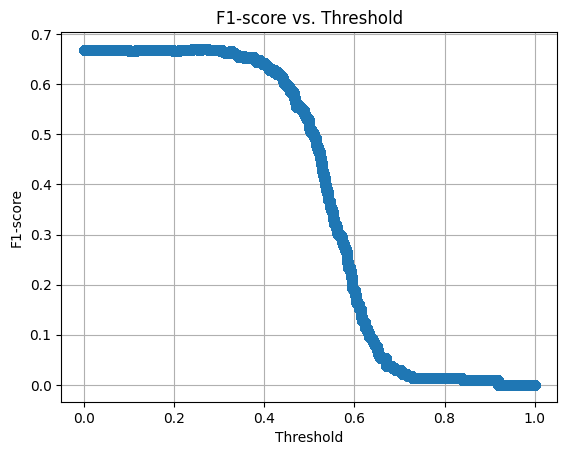

In [42]:
import matplotlib.pyplot as plt

f1_scores = []
for t in thresholds:
    y_pred_thresh = (y_val_probs >= t).astype(int)
    f1 = compute_f1_score(y_val.ravel(), y_pred_thresh.ravel())
    f1_scores.append(f1)

# Graficar el F1-score contra el threshold
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score vs. Threshold')
plt.grid(True)
plt.show()


In [ ]:
def feature_correlation(X, y):
    """
    Calcula la correlación de Pearson entre cada columna de X y el vector y.
    """
    mean_y = np.mean(y)
    correlations = []
    for i in range(X.shape[1]):
        xi = X[:, i]
        mean_xi = np.mean(xi)
        numerator = np.sum((xi - mean_xi) * (y - mean_y))
        denominator = np.sqrt(np.sum((xi - mean_xi)**2) * np.sum((y - mean_y)**2))
        corr = numerator / (denominator + 1e-8)
        correlations.append(corr)
    return np.array(correlations)

def select_top_features(X, y, top_k=10):
    corrs = feature_correlation(X, y)
    top_indices = np.argsort(np.abs(corrs))[-top_k:]
    return X[:, top_indices], top_indices  # retorna también los índices para seguimiento






In [ ]:
# Cargar datos
train_df = pd.read_csv("train_df.csv")

# --- Preprocesamiento de train_df ---
train_df["genero"] = train_df["genero"].map({"M": 1, "F": 0})
y = train_df["target"].values.reshape(-1, 1)
paciente_ids_train = train_df["paciente_id"].values
X_df = train_df.drop(columns=["paciente_id", "target"])

# Normalizar columnas numéricas (menos 'genero')
numeric_cols = X_df.columns.tolist()
numeric_cols.remove("genero")
means = X_df[numeric_cols].mean()
stds = X_df[numeric_cols].std()
X_df[numeric_cols] = (X_df[numeric_cols] - means) / stds

# Convertir a numpy y normalizar L2
X = X_df.values.astype(np.float64)
X = normalize(X)

# Features polinomiales
X_poly_df = add_polynomial_features(X)

# Normalizar features extendidas
means_poly = X_poly_df.mean()
stds_poly = X_poly_df.std()
X_poly_df = (X_poly_df - means_poly) / stds_poly
X_final_poly = X_poly_df.values

# Entrenar el modelo final
theta, bias = train_logistic_regression(X_final_poly, y, lr=0.1, epochs=1000)

# Generar predicciones para los mismos datos de entrenamiento
y_probs = sigmoid(np.dot(X_final_poly, theta) + bias)

# Usar el mejor threshold encontrado
best_thresh = 0.25
y_preds = (y_probs >= best_thresh).astype(int).flatten()

# Crear archivo de submission con train
submission_df = pd.DataFrame({
    "paciente_id": paciente_ids_train,
    "target": y_preds
})
submission_df.to_csv("submission.csv", index=False)
print("✅ submission.csv generado con threshold = 0.25 usando train_df.")


In [40]:
import pandas as pd
import numpy as np

# Funciones necesarias
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def normalize(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0] = 1
    return X / norms

def train_logistic_regression(X, y, lr=0.2, epochs=2000):
    m, n = X.shape
    theta = np.zeros((n, 1))
    bias = 0

    for _ in range(epochs):
        z = np.dot(X, theta) + bias
        h = sigmoid(z)
        error = h - y
        grad_theta = np.dot(X.T, error) / m
        grad_bias = np.mean(error)

        theta -= lr * grad_theta
        bias -= lr * grad_bias

    return theta, bias

def add_polynomial_and_cross_features_np(X):
    """
    Agrega términos cuadráticos, cúbicos y cruzados usando solo numpy.
    """
    n_samples, n_features = X.shape
    features = [X]

    # Cuadrados y cubos
    features.append(X ** 2)
    features.append(X ** 3)

    # Interacciones cruzadas (combinaciones únicas i < j)
    cross_terms = []
    for i in range(n_features):
        for j in range(i + 1, n_features):
            cross = (X[:, i] * X[:, j]).reshape(-1, 1)
            cross_terms.append(cross)
    if cross_terms:
        features.append(np.hstack(cross_terms))

    return np.hstack(features)

def f1_score(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1

def find_best_threshold(y_true, y_probs):
    thresholds = np.linspace(0.01, 0.99, 200)
    best_f1 = 0
    best_thresh = 0.5
    for thresh in thresholds:
        preds = (y_probs >= thresh).astype(int)
        f1 = f1_score(y_true, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    return best_thresh, best_f1

# === Cargar y procesar datos ===
df = pd.read_csv("train_df.csv")
df["genero"] = df["genero"].map({"M": 1, "F": 0})
y = df["target"].values.reshape(-1, 1)
paciente_ids = df["paciente_id"]
X_df = df.drop(columns=["paciente_id", "target"])

# Normalización numérica
numeric_cols = X_df.columns.tolist()
numeric_cols.remove("genero")
means = X_df[numeric_cols].mean()
stds = X_df[numeric_cols].std()
X_df[numeric_cols] = (X_df[numeric_cols] - means) / stds

# L2 normalization
X = normalize(X_df.values.astype(np.float64))

# Features polinomiales y cúbicas cruzadas
X_poly = add_polynomial_and_cross_features_np(X)

# Normalización polinomial
X_poly = (X_poly - X_poly.mean(axis=0)) / (X_poly.std(axis=0) + 1e-8)

# Entrenar modelo
theta, bias = train_logistic_regression(X_poly, y, lr=0.2, epochs=2000)

# Predecir probabilidades
y_probs = sigmoid(np.dot(X_poly, theta) + bias)



# Buscar mejor threshold
best_thresh, best_f1 = find_best_threshold(y.flatten(), y_probs.flatten())

#best_thresh = 0.2715942

print(f"📊 Mejor threshold encontrado: {best_thresh:.6f} con F1-score: {best_f1:.6f}")

# Predicción final
y_preds = (y_probs >= best_thresh).astype(int).flatten()

# Guardar submission
submission_df = pd.DataFrame({
    "paciente_id": paciente_ids,
    "target": y_preds
})
submission_df.to_csv("submission.csv", index=False)
print("✅ submission.csv generado con features extendidas y threshold optimizado.")


📊 Mejor threshold encontrado: 0.310402 con F1-score: 0.665657
✅ submission.csv generado con features extendidas y threshold optimizado.
